# 1. Data Preparation

## 1.1 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%ls

sample_data/


In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks"

/content/gdrive/MyDrive/Colab Notebooks


## 1.2 Download and Extract Data

In [ ]:
! git clone https://github.com/denopas/TTC-3600

Cloning into 'TTC-3600'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


In [ ]:
%cd "TTC-3600"

/content/gdrive/MyDrive/Colab Notebooks/TTC-3600


In [ ]:
! unrar x "TTC-3600_Orj.rar"

# 2. Data Preprocessing

## 2.1 Convert data to csv file

In [ ]:
import os
import pandas as pd


def read_sample_file(file_path):
    lines = []
    with open(file_path, "rt", encoding="utf-8") as f:
        for line in f:
            line = line.replace("\n", "").strip()
            if len(line) > 1:
                lines.append(line)
    return " ".join(lines).strip()


data_dir = "./TTC-3600_Orj"
csv_path = "./TTC-3600_Orj.csv"
data_dict = {"text": [], "label": []}
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for sample_name in os.listdir(class_dir):
        sample_path = os.path.join(class_dir, sample_name)
        sample_text = read_sample_file(sample_path)
        data_dict["text"].append(sample_text)
        data_dict["label"].append(class_name)

data_frame = pd.DataFrame(data_dict)
data_frame.to_csv(csv_path, encoding="utf-8", index=False)

## 2.2 Stemming

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import nltk


nltk.download('punkt')


csv_path = "./TTC-3600_Orj.csv"
stemmed_csv_path = "./TTC-3600_Stem.csv"
data_frame = pd.read_csv(csv_path)

sentences = data_frame["text"].values

stemmer = PorterStemmer()

sentences_tokenized = []
for sentence in sentences:
    tokens = word_tokenize(sentence)
    sentence_tokenized = " ".join([stemmer.stem(t) for t in tokens])
    sentences_tokenized.append(sentence_tokenized)

data_frame['text'] = sentences_tokenized
data_frame.to_csv(stemmed_csv_path, encoding="utf-8", index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2.2 Data Visualization & Exploration

#### Class Counts

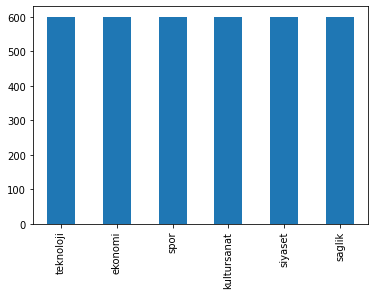

In [ ]:
import pandas as pd


csv_path = "./TTC-3600_Orj.csv"
data_frame = pd.read_csv(csv_path)
data_frame["label"].value_counts().plot.bar()

### Word Counts

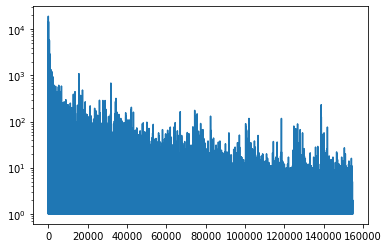

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np


csv_path = "./TTC-3600_Orj.csv"
data_frame = pd.read_csv(csv_path)
sentences = [sentence.split(" ") for sentence in  data_frame["text"].values]
words = np.hstack(sentences)
word_counts = Counter(words)
word_counts_df = pd.DataFrame({
    "word": word_counts.keys(),
    "count": word_counts.values()
})
word_counts_df["count"].plot(logy=True)

# 3. Feature Extraction

## 3.1 TF-IDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


csv_path = "./TTC-3600_Stem.csv"
features_path = "./tf-idf.csv"
vectorizer_path = "./vectorizer"
data_frame = pd.read_csv(csv_path)
texts = data_frame["text"].values.tolist()
labels = data_frame["label"].values.tolist()
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                              analyzer="word",
                              use_idf=True,
                              lowercase=False,
                              encoding="utf-8",
                              max_features=10000)
feats = vectorizer.fit_transform(texts)
feats = feats.astype("float32")
feats = feats.toarray()
feat_frame = pd.DataFrame({"feature": [" ".join([str(f) for f in feat]) for feat in feats], "label": labels})
feat_frame.to_csv(features_path, encoding="utf-8", index=False)

with open(vectorizer_path, "wb") as f:
    pickle.dump(vectorizer, f)

# 4. Classification

## 4.1 K-Nearest Neighbour (KNN)

In [ ]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import pandas as pd


def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))


class KNN:

    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # return the most common class label
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]

In [ ]:
random.seed(123)

features_path = "./tf-idf.csv"
feat_frame = pd.read_csv(features_path)
features = np.asarray([[np.float(f) for f in feat.split(" ")] for feat in feat_frame["feature"].values])
labels = feat_frame["label"].values


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=1/6, random_state=1234, stratify=labels)

k = 3
clf = KNN(k=k)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("KNN classification accuracy", accuracy_score(y_test, predictions))

KNN classification accuracy 0.8666666666666667


### Single sample test

In [ ]:
import pickle

with open(vectorizer_path, "rb") as f:
    vectorizer = pickle.load(f)

In [ ]:
texts = [
    "ekonomi",
    "sağlık"
]

texts_stemmed = []
for text in texts:
    tokens = word_tokenize(text)
    text_tokenized = " ".join([stemmer.stem(t) for t in tokens])
    texts_stemmed.append(text_tokenized)

feats = vectorizer.transform(texts_stemmed)
feats = feats.astype("float32")
feats = feats.toarray()

print(clf.predict(feats))

['ekonomi' 'saglik']


### Scikit-Learn Implementation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("KNN classification accuracy", accuracy_score(y_test, predictions))

KNN classification accuracy 0.86


## 4.2 Support Vector Machines (SVM)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit


class SVM(BaseEstimator, ClassifierMixin):

    def __init__(self, lr=0.001, lambda_param=0.0001, n_iters=100):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):
        # Store the classes seen during fit
        self.classes_ = np.unique(y)

        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

        return self

    def predict_proba(self, X):
        approx = np.dot(X, self.w) - self.b
        probs_positive = expit(approx)
        probs = np.vstack([1 - probs_positive, probs_positive]).T
        return probs

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [ ]:
features_path = "./tf-idf.csv"
feat_frame = pd.read_csv(features_path)

train_frame, test_frame = train_test_split(feat_frame, test_size=1/6, random_state=123, stratify=feat_frame["label"])

X_train = np.asarray([[np.float(f) for f in feat.split(" ")]for feat in train_frame["feature"].values])
y_train = train_frame["label"].values

X_test = np.asarray([[np.float(f) for f in feat.split(" ")] for feat in test_frame["feature"].values])
y_test = test_frame["label"].values

clf = OneVsRestClassifier(SVM()).fit(X_train, y_train)
predictions = clf.predict(X_test)

print(f"SVM classification accuracy", accuracy_score(y_test, predictions))

SVM classification accuracy 0.905


### One-vs-Rest Implementation

In [ ]:
num_classes = 6
class_conversion_dict = {
    0: "ekonomi",
    1: "kultursanat",
    2: "saglik",
    3: "siyaset",
    4: "spor",
    5: "teknoloji"
}

clfs = [SVM() for i in range(num_classes)]

for i in range(num_classes):
    class_replace_dict = dict((v, -1) for k, v in class_conversion_dict.items())
    class_replace_dict[class_conversion_dict[i]] = 1

    train_frame_r = train_frame.replace({"label": class_replace_dict})

    X_train = np.asarray([[np.float(f) for f in feat.split(" ")]for feat in train_frame_r["feature"].values])
    y_train = train_frame_r["label"].values

    clfs[i].fit(X_train, y_train)

    predictions = clfs[i].predict(X_train)
    print(f"SVM train classification accuracy for {i} {class_conversion_dict[i]}", accuracy_score(y_train, predictions))


predictions_list = []

for i in range(num_classes):
    class_replace_dict = dict((v, -1) for k, v in class_conversion_dict.items())
    class_replace_dict[class_conversion_dict[i]] = 1

    test_frame_r = test_frame.replace({"label": class_replace_dict})

    X_test = np.asarray([[np.float(f) for f in feat.split(" ")] for feat in test_frame_r["feature"].values])
    y_test = test_frame_r["label"].values

    predictions = clfs[i].predict(X_test)
    predictions_list.append(predictions)
    print(f"SVM test classification accuracy for {i} {class_conversion_dict[i]}", accuracy_score(y_test, predictions))


prediction_idxs_tuple = np.where(np.array(predictions_list).T == 1)
prediction_idxs = np.ones(600,) * 6
prediction_idxs[prediction_idxs_tuple[0]] = prediction_idxs_tuple[1]
label_idxs = test_frame.replace({"label": dict((v, k) for k, v in class_conversion_dict.items())})["label"].values
print("SVM overall classification accuracy", accuracy_score(label_idxs, prediction_idxs))

SVM train classification accuracy for 0 ekonomi 0.8696666666666667
SVM train classification accuracy for 1 kultursanat 0.854
SVM train classification accuracy for 2 saglik 0.9103333333333333
SVM train classification accuracy for 3 siyaset 0.949
SVM train classification accuracy for 4 spor 0.9283333333333333
SVM train classification accuracy for 5 teknoloji 0.8833333333333333
SVM test classification accuracy for 0 ekonomi 0.865
SVM test classification accuracy for 1 kultursanat 0.8466666666666667
SVM test classification accuracy for 2 saglik 0.905
SVM test classification accuracy for 3 siyaset 0.9333333333333333
SVM test classification accuracy for 4 spor 0.8966666666666666
SVM test classification accuracy for 5 teknoloji 0.8566666666666667
SVM overall classification accuracy 0.315


### Scikit-Learn Implementation

In [ ]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("SVM classification accuracy", accuracy_score(y_test, predictions))

SVM classification accuracy 0.9166666666666666


# References

1. https://github.com/denopas/TTC-3600
2. https://github.com/gsamil/algorithms